# Assignment 1 Bonus



## 1. Improve performance of the neural network

The three avenues of improvement I chose to explore are:

1. **Better weight initialization**
2. **Better optimization algorithm**
3. **Introduce non-linearity and deepen the network**

In [1]:
# read in pickled cifar-10 data
import pickle
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# read in the data and convert the pixel values to float32
train = unpickle('cifar10/data_batch_1')
val = unpickle('cifar10/data_batch_2')
test = unpickle('cifar10/test_batch')
x_train, y_train = train[b"data"].astype(np.float32), np.array(train[b"labels"])
x_val, y_val = val[b"data"].astype(np.float32), np.array(val[b"labels"])
x_test, y_test = test[b"data"].astype(np.float32), np.array(test[b"labels"])


# drop 30% of val for ease of use
ind = int(len(x_val)*0.3)
ind = np.random.permutation(len(x_val))[:ind] # there may otherwise be some structure in the data
x_val, y_val = x_val[ind], y_val[ind]

In [2]:
# normalize the input data with the mean and std of the training data
mean, std = x_train.mean(), x_train.std()
x_train, x_val, x_test = (x_train - mean) / std, (x_val - mean) / std, (x_test - mean) / std

# one-hot encode the labels
y_train, y_val, y_test = np.eye(10)[y_train], np.eye(10)[y_val], np.eye(10)[y_test]

### 1. **Better weight initialization**

In an untrained neural network, the cross-entropy loss tends to grow as the model's parameters expand due to the increasing variance of the output logits. This is caused by the accumulation of normally distributed weights, which leads to extremely small predicted probabilities for the true class. In the model's matmuls, we multiply and sum together normally distributed weights with our input data. This results in the output logits having a higher variance than the input data / weights themselves.

When the variance of the output logits is high, the softmax function assigns most of the probability mass to a single element. For example, if the output logits are [50, 100, 150], the softmax function would result in predicted probabilities close to [0, ~0, ~1]. In this case, the network has a 1/10 chance of being correct, and when it is correct, the log-likelihood is log(1), which is good. However, 9/10 times, the network gets log(0), which is bad and leads to a large cross-entropy loss.

As networks deepen this problem becomes more pronounced. The variance of the output logits grows with the number of layers and hidden dimension sizes, and the cross-entropy loss grows with the variance.

In contrast, when the output logits are roughly normally distributed with a mean of 0 and a standard deviation of 1, such as [-0.2, 0.3, 0.5], the softmax function would result in more evenly distributed predicted probabilities, like [~0.1, ~0.2, ~0.7].

In our scenario, since the variance is small, all probabilities will be close to 1/10 and therefore the expected loss is: $-\log{\frac{1}{10}} = \log{10} \approx 2.3$

To mitigate the growth of cross-entropy loss in untrained neural networks, proper parameter initialization techniques are crucial. These techniques aim to control the scale of the output logits and prevent the loss from growing excessively during the initial stages of training, allowing the network to learn effectively from the beginning of the training process.

In Assingment 1, we manually chose std $=0.01$ to mitigate this issue but if the were to increase the number of parameters, the loss would grow.

Therefore I chose to implement xavier initialization which takes into account the number of parameters in the layer and normalizes the weights appropriately.


### First let's visualize the difference between the two initialization techniques

In [3]:
import torch
import torch.nn.functional as F

y = torch.eye(10)
losses_normal = []

with torch.no_grad():
    for param in range(10000):
        y_hat = torch.randn(10, param) @ torch.randn(param, 10)
        loss = -(y * F.log_softmax(y_hat, dim=-1)).sum(dim=-1).mean()
        losses_normal.append(loss.item())


KeyboardInterrupt: 

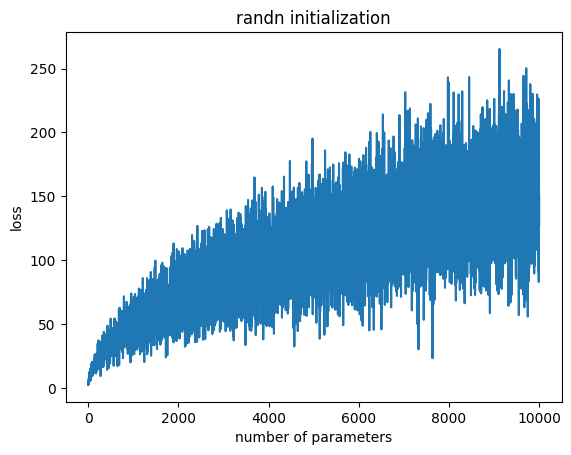

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_normal)
plt.title("randn initialization")
plt.xlabel("number of parameters")
plt.ylabel("loss")
plt.show()

In [ ]:
def xavier(n_in: int, n_out: int):
    bound = torch.sqrt(torch.tensor(6.0) / (n_in + n_out))
    return torch.empty(n_in, n_out).uniform_(-bound, bound)


y = torch.eye(10)
losses_xavier = []

with torch.no_grad():
    for param in range(10000):
        y_hat = xavier(10, param) @ xavier(param, 10)
        loss = -(y * F.log_softmax(y_hat, dim=-1)).sum(dim=-1).mean()
        losses_xavier.append(loss.item())

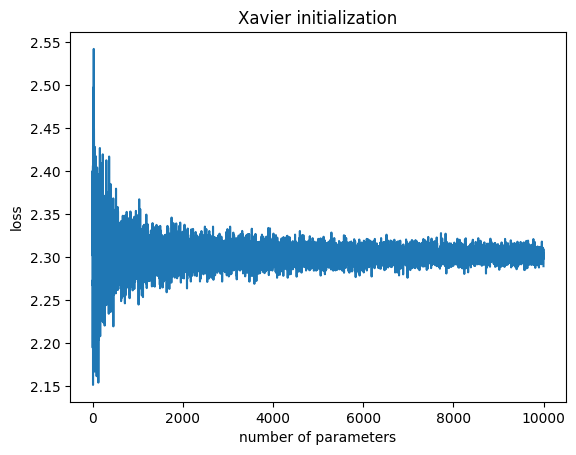

In [ ]:
plt.plot(losses_xavier)
plt.title("Xavier initialization")
plt.xlabel("number of parameters")
plt.ylabel("loss")
plt.show()

### 2. Better Optimization Algorithm

I chose to implement the Adam optimizer

In [3]:
import numpy as np
from tensor import Tensor

# Adam is essentially AdaGrad and RMSProp with bias correction
class Adam:
    def __init__(self, params: list[Tensor], lr: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, epsilon: float = 1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * p.grad ** 2
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            p.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)
            
class SGD: # the 'stochastic' nature depends on the usage, not the implementation, but this is clear
    def __init__(self, params:list[Tensor], lr:float=0.01):
        self.params = params
        self.lr = lr

    def step(self): # perform the update
        for p in self.params:
            p.data -= self.lr * p.grad
            
    # most tensors are created at runtime and therefore we need not zero the gradients
    # however, weights and biases persist and we need to zero the gradients between each gradient descent step
    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

In [4]:
class Model:
    def __init__(self):
        self.w = Tensor.randn(3072, 10) * 0.01
        self.b = Tensor.randn(10) * 0.01
        
    def __call__(self, x):
        return x @ self.w + self.b
    
    def parameters(self):
        return [self.w, self.b]

In [5]:
from tqdm import tqdm

np.random.seed(400)

EPOCHS = 40
BATCH_SIZE = 100
LR = 0.001
LAMBDA = 0.0

model = Model()
optim = SGD(model.parameters(), lr=LR)

def train(model, optim, x_train, y_train, x_val, y_val):
    train_losses_epoch = []
    val_losses_epoch = []
    for _ in tqdm(range(EPOCHS)):
        train_losses = []
        permutation = np.random.permutation(len(x_train))
        for i in range(len(x_train) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_train[idxs])
            y = Tensor(y_train[idxs])
            y_hat = model(x)
            # cross-entropy loss with L2 regularization
            # sum over classes, then mean over batch for cross-entropy
            loss = -(y * y_hat.log_softmax()).sum().mean() + LAMBDA * (model.w ** 2).sum().sum()
            # y acts as a selector so GD minimizes -log(y_hat) i.e. maximizing the likelihood
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            train_losses.append(loss.data)
        
        val_losses = []
        permutation = np.random.permutation(len(x_val))
        for i in range(len(x_val) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_val[idxs])
            y = Tensor(y_val[idxs])
            y_hat_val = model(x)
            val_loss = -(y * y_hat_val.log_softmax()).sum().mean() + LAMBDA * ((model.w ** 2).sum().sum())
            val_losses.append(val_loss.data)

        
        train_losses_epoch.append(np.mean(train_losses))
        val_losses_epoch.append(np.mean(val_losses))
        
    return train_losses_epoch, val_losses_epoch

train_losses_sgd, val_losses_sgd = train(model, optim, x_train, y_train, x_val, y_val)

  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:02<01:18,  2.02s/it]


KeyboardInterrupt: 

In [17]:

np.random.seed(400)

EPOCHS = 40
BATCH_SIZE = 100
LR = 0.001
LAMBDA = 0.0

model = Model()
optim = Adam(model.parameters(), lr=LR)

train_losses_adam, val_losses_adam = train(model, optim, x_train, y_train, x_val, y_val)

100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


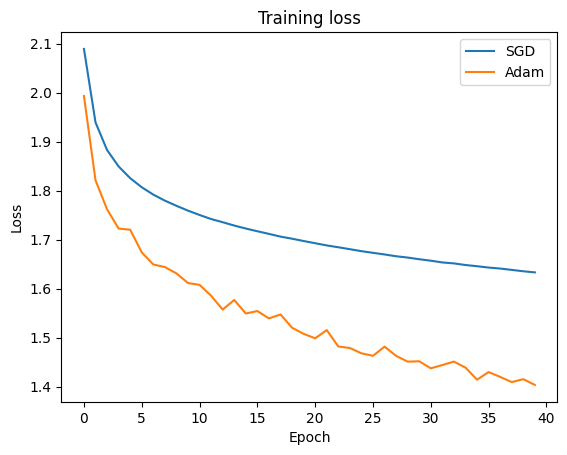

In [18]:
plt.plot(train_losses_sgd, label="SGD")
plt.plot(train_losses_adam, label="Adam")
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

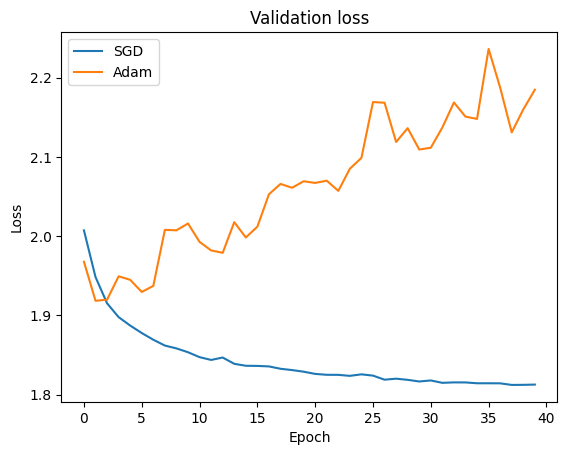

In [19]:
plt.plot(val_losses_sgd, label="SGD")
plt.plot(val_losses_adam, label="Adam")
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Adam is more stable and converges faster than SGD.

This can be seen from the the graphs above. Adam is very quick to overfit so one should include some regularization techniques to prevent this.

### 3. Introduce non-linearity and deepen the network

Non-linearity is crucial for deep networks to learn complex patterns in the data. In the original model, we only used a single linear layer without any activation functions. This severely limits the model's capacity to learn complex patterns and relationships in the data.

Adding more layers without non-linear activation functions would not improve the model's performance, as the composition of linear functions is still a linear function.

In [6]:
class MLP:
    def __init__(self):
        self.w1 = Tensor.xavier(3072, 128)
        self.b1 = Tensor.randn(128) # the bias does not contribute to the number of parameters discussion above in the same way as weights
        self.w2 = Tensor.xavier(128, 10)
        self.b2 = Tensor.randn(10)
        
    def __call__(self, x:Tensor):
        x = (x @ self.w1 + self.b1).relu()
        return x @ self.w2 + self.b2
    
    def parameters(self):
        return [self.w1, self.b1, self.w2, self.b2]
        

In [7]:
from tqdm import tqdm

np.random.seed(400)

EPOCHS = 40
BATCH_SIZE = 100
LR = 0.001
LAMBDA = 0.004

model = MLP()
optim = Adam(model.parameters(), lr=LR)

def train(model, optim, x_train, y_train, x_val, y_val):
    train_losses_epoch = []
    val_losses_epoch = []
    for _ in tqdm(range(EPOCHS)):
        train_losses = []
        permutation = np.random.permutation(len(x_train))
        for i in range(len(x_train) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_train[idxs])
            y = Tensor(y_train[idxs])
            y_hat = model(x)
            # cross-entropy loss with L2 regularization
            # sum over classes, then mean over batch for cross-entropy
            loss = -(y * y_hat.log_softmax()).sum().mean()
            loss += LAMBDA * ((model.w1 ** 2).sum().sum() + (model.w2 ** 2).sum().sum())
            # y acts as a selector so GD minimizes -log(y_hat) i.e. maximizing the likelihood
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            train_losses.append(loss.data)
        
        val_losses = []
        permutation = np.random.permutation(len(x_val))
        for i in range(len(x_val) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_val[idxs])
            y = Tensor(y_val[idxs])
            y_hat_val = model(x)
            val_loss = -(y * y_hat_val.log_softmax()).sum().mean()
            val_loss += LAMBDA * ((model.w1 ** 2).sum().sum() + (model.w2 ** 2).sum().sum())
            val_losses.append(val_loss.data)

        
        train_losses_epoch.append(np.mean(train_losses))
        val_losses_epoch.append(np.mean(val_losses))
        
    return train_losses_epoch, val_losses_epoch

train_losses, val_losses = train(model, optim, x_train, y_train, x_val, y_val)


 12%|█▎        | 5/40 [00:13<01:33,  2.68s/it]


KeyboardInterrupt: 

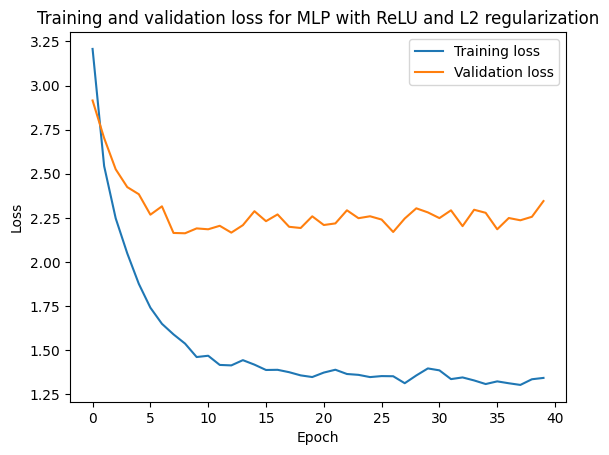

In [12]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Training and validation loss for MLP with ReLU and L2 regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
def accuracy(y, y_hat):
    return np.mean(y.argmax(axis=1) == y_hat.argmax(axis=1))

accuracy(y_train, model(Tensor(x_train)).data), accuracy(y_val, model(Tensor(x_val)).data), accuracy(y_test, model(Tensor(x_test)).data)
# 0.7147, 0.4246666666666667, 0.4411

(0.028, 0.034666666666666665, 0.0345)

## 2. Train network - multiple binary cross-entropy losses

To implement this for the Tensor autograd approach, we simply need to implement the .log and .sigmoid functions.

In [4]:
class Model:
    def __init__(self):
        self.w1 = Tensor.xavier(3072, 128)
        self.b1 = Tensor.randn(128)
        self.w2 = Tensor.xavier(128, 10)
        self.b2 = Tensor.randn(10)
        
    def __call__(self, x:Tensor):
        x = (x @ self.w1 + self.b1).relu()
        return (x @ self.w2 + self.b2).sigmoid()
        
    def parameters(self):
        return [self.w1, self.b1, self.w2, self.b2]

In [9]:
from tensor import Tensor

from tqdm import tqdm

np.random.seed(400)

EPOCHS = 10
BATCH_SIZE = 100
LR = 0.001
LAMBDA = 0.004

model = Model()
optim = Adam(model.parameters(), lr=LR)

def train(model, optim, x_train, y_train, x_val, y_val):
    train_losses_epoch = []
    val_losses_epoch = []
    for _ in tqdm(range(EPOCHS)):
        train_losses = []
        permutation = np.random.permutation(len(x_train))
        for i in range(len(x_train) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_train[idxs])
            y = Tensor(y_train[idxs])
            y_hat = model(x)
            # cross-entropy loss with L2 regularization
            # sum over classes, then mean over batch for cross-entropy
            loss_m_bce = -((1.0 - y) * (1.0 - y_hat).log()) + (y * y_hat.log()).sum().mean()
            loss_m_bce += LAMBDA * ((model.w1 ** 2).sum().sum() + (model.w2 ** 2).sum().sum())
            # y acts as a selector so GD minimizes -log(y_hat) i.e. maximizing the likelihood
            
            optim.zero_grad()
            loss_m_bce.backward()
            optim.step()
            
            train_losses.append(loss_m_bce.data)
        
        val_losses = []
        permutation = np.random.permutation(len(x_val))
        for i in range(len(x_val) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_val[idxs])
            y = Tensor(y_val[idxs])
            y_hat_val = model(x)
            val_loss = ((1.0 - y) * (1.0 - y_hat_val).log()) + (y * y_hat_val.log()).sum().mean()
            val_loss += LAMBDA * ((model.w1 ** 2).sum().sum() + (model.w2 ** 2).sum().sum())
            val_losses.append(val_loss.data)

        
        train_losses_epoch.append(np.mean(train_losses))
        val_losses_epoch.append(np.mean(val_losses))
        
    return train_losses_epoch, val_losses_epoch

train_losses, val_losses = train(model, optim, x_train, y_train, x_val, y_val)


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


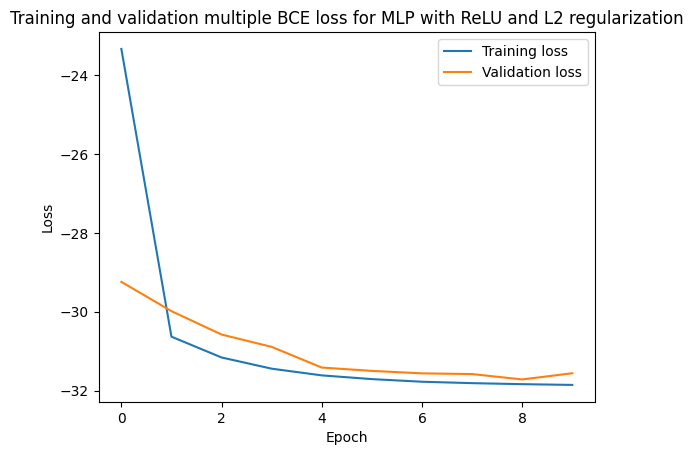

In [10]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Training and validation multiple BCE loss for MLP with ReLU and L2 regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
accuracy(y_train, model(Tensor(x_train)).data), accuracy(y_val, model(Tensor(x_val)).data), accuracy(y_test, model(Tensor(x_test)).data)

(0.028, 0.034666666666666665, 0.0345)